In [25]:
pip install pandas==1.5.3 numpy==1.23.5 scipy==1.10.1 pandas-datareader yfinance matplotlib scikit-learn==1.2.2 statsmodels==0.13.5 arch==5.5.0 numba==0.56.4

Note: you may need to restart the kernel to use updated packages.


# 1. Data Preprocessing and Cleaning

In [26]:
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr

# Define date range
start, end = '2018-01-01', '2024-12-31'

# Fetch auto‑adjusted Close prices for given tickers
def fetch_market_data(tickers, start, end):
    raw = yf.download(tickers, start=start, end=end, progress=False, auto_adjust=True)
    if isinstance(raw.columns, pd.MultiIndex):
        df = raw['Close']
    else:
        df = raw['Close'].to_frame(name=tickers if isinstance(tickers, str) else raw['Close'].name)
    return df


# Fetch FRED series
def fetch_fred_series(series, start, end):
    return pd.concat(
        [pdr.DataReader(s, 'fred', start, end).rename(columns={s: s})
         for s in series],
        axis=1
    )

# Specify tickers and FRED series
stock_tickers = ['AAPL', 'MSFT']
etf_tickers   = ['XLK']
fred_series   = ['DGS10', 'CPIAUCSL']

# Download
prices_stock = fetch_market_data(stock_tickers, start, end)
prices_etf   = fetch_market_data(etf_tickers, start, end)
fred_df      = fetch_fred_series(fred_series, start, end)

# Align on business days
data = pd.concat([prices_stock, prices_etf, fred_df], axis=1)
data = data.asfreq('B').ffill().bfill()

# Compute log‑returns for equities & ETF
returns = np.log(data[stock_tickers + etf_tickers] / data[stock_tickers + etf_tickers].shift(1)).dropna()

# Compute daily changes for yields and CPI
yields = data[['DGS10']].diff().dropna()
cpi = data[['CPIAUCSL']].pct_change().rename(columns={'CPIAUCSL': 'CPI'}).dropna()

# Combine into feature matrix and standardize
features   = pd.concat([returns, yields, cpi], axis=1).dropna()
features_z = (features - features.mean()) / features.std()

print("Features index & columns:\n", features_z.tail())


Features index & columns:
                 AAPL      MSFT       XLK     DGS10       CPI
2024-12-25 -0.052991 -0.051297 -0.045999 -0.020716 -0.121659
2024-12-26  0.114812 -0.206874 -0.004921 -0.199145 -0.121659
2024-12-27 -0.758499 -1.027731 -0.872757  0.693000 -0.121659
2024-12-30 -0.759642 -0.796948 -0.836533 -1.269719 -0.121659
2024-12-31 -0.052991 -0.051297 -0.045999  0.514571 -0.121659


# 2. Exploratory Data Analysis

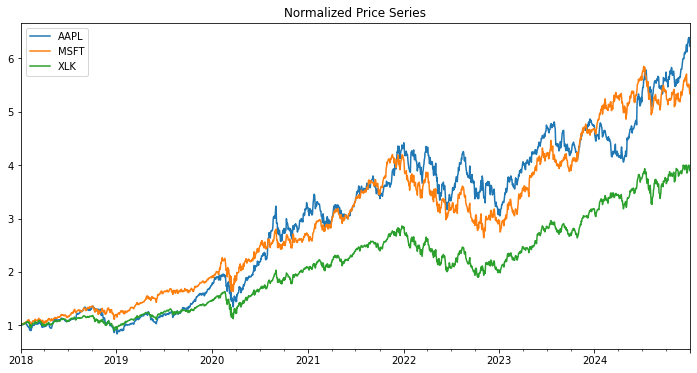

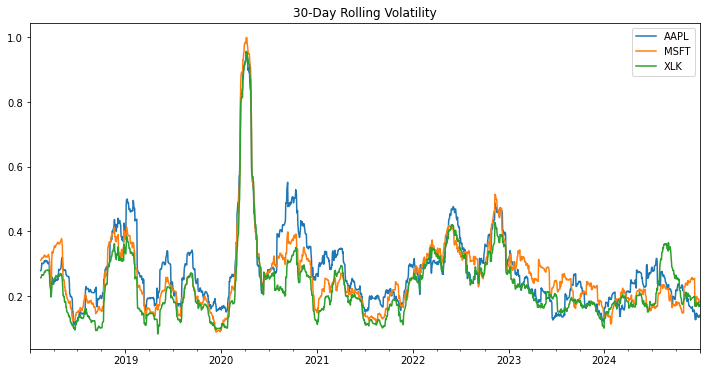

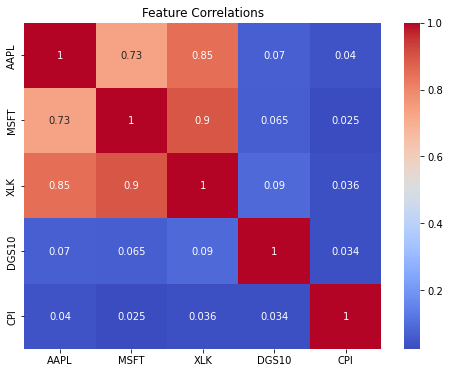

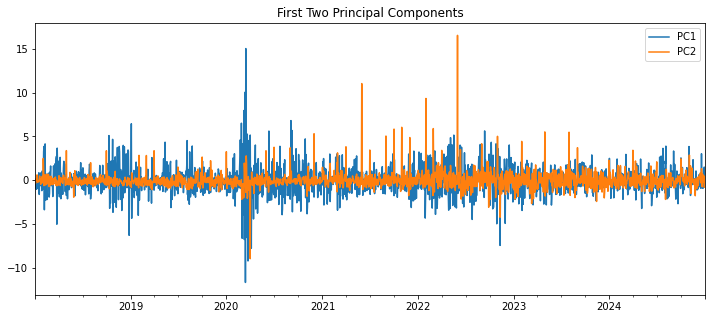

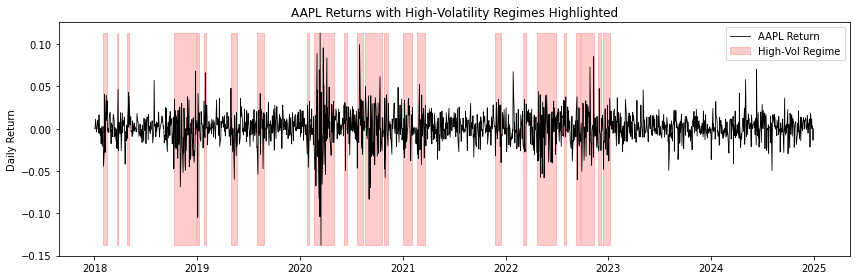

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Normalize prices for comparison
norm = data[stock_tickers + etf_tickers].div(data.iloc[0][stock_tickers + etf_tickers])
norm.plot(figsize=(12,6), title='Normalized Price Series')
plt.show()

# 30‑day rolling volatility (annualized)
rv = returns.rolling(30).std() * np.sqrt(252)
rv.plot(figsize=(12,6), title='30‑Day Rolling Volatility')
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(features.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()

# PCA on z‑scored features
pca = PCA(2).fit(features_z)
pc = pca.transform(features_z)
pc_df = pd.DataFrame(pc, index=features_z.index, columns=['PC1','PC2'])

pc_df.plot(figsize=(12,5), title='First Two Principal Components')
plt.show()

# Markov regime switching on AAPL returns
mod = MarkovRegression(returns['AAPL'], k_regimes=2, trend='c', switching_variance=True)
res = mod.fit(em_iter=10)
reg = res.smoothed_marginal_probabilities[0]

probs = res.smoothed_marginal_probabilities  # DataFrame with columns 0 and 1
# compute realized vol
vol30 = returns['AAPL'].rolling(30).std() * np.sqrt(252)

# average vol in each regime
avg0 = vol30[probs[0] > 0.5].mean()
avg1 = vol30[probs[1] > 0.5].mean()

# pick the regime with the higher realized vol
high_regime = 0 if avg0 > avg1 else 1

#b oolean Series marking high‑vol days
is_high_vol = (probs[high_regime] > 0.5)

# merge out any short (<5‑day) spikes so only multi‑week regimes remain
runs = (is_high_vol != is_high_vol.shift()).cumsum()
# count run lengths
lengths = runs.map(runs.value_counts())
# keep only runs where is_high_vol is true and length >= 5
mask = is_high_vol & (lengths >= 5)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(returns.index, returns['AAPL'], color='black', lw=0.8, label='AAPL Return')
# shade only the long high‑vol regimes
ax.fill_between(returns.index, returns['AAPL'].min(), returns['AAPL'].max(), where=mask, color='red', alpha=0.2, label='High‑Vol Regime')
ax.set_title('AAPL Returns with High‑Volatility Regimes Highlighted')
ax.set_ylabel('Daily Return')
ax.legend()
plt.tight_layout()
plt.show()


# 3. Statistical Modeling and Forecasting

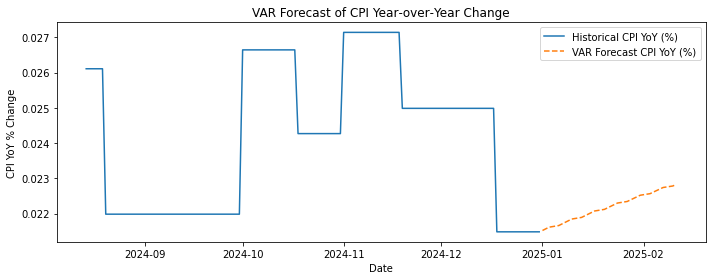

CPI YoY Forecast → RMSE: 0.0026, MAE: 0.0024


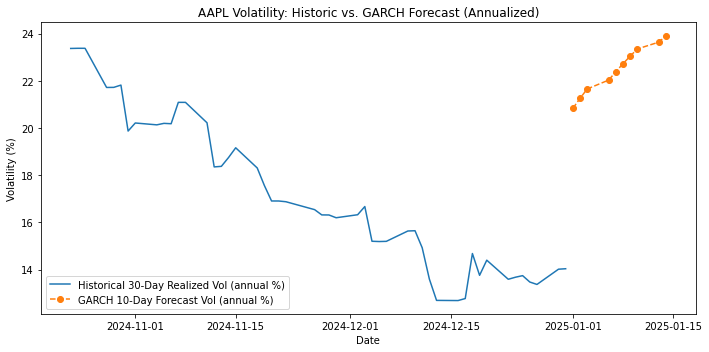

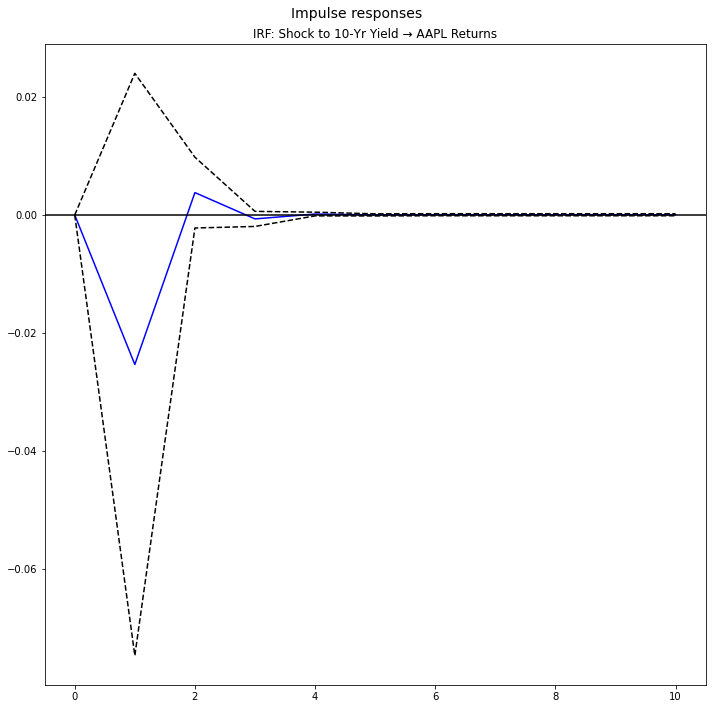

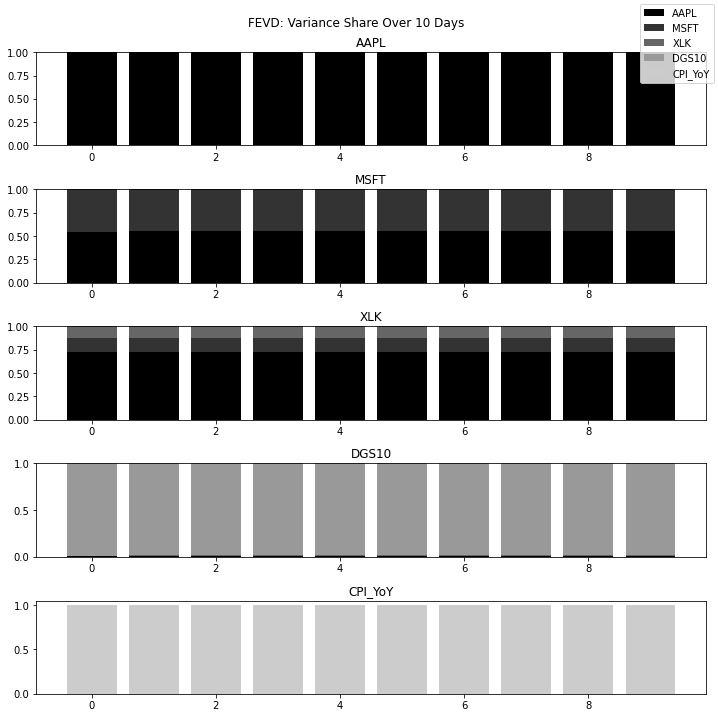

Granger Causality p‑values (DGS10 causes AAPL):
  lag=1: p=0.2494
  lag=2: p=0.3380
  lag=3: p=0.0853
  lag=4: p=0.1477
  lag=5: p=0.2214


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from arch.__future__ import reindexing # Supress arch deprecation warnings
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# VAR fit and 30‑day forecast
# Interpolate CPI to daily and recompute YoY series
data['CPIAUCSL'] = data['CPIAUCSL'].interpolate(method='time')
cpi_yoy = (
    data['CPIAUCSL']
    .pct_change(252)
    .rename('CPI_YoY')
    .dropna()
)

# Rebuild features and standardize
features   = pd.concat([returns, yields, cpi_yoy], axis=1).dropna()
features_z = (features - features.mean()) / features.std()

# Fit VAR and forecast 30 days ahead
from statsmodels.tsa.vector_ar.var_model import VAR

var_model = VAR(features_z)
lag_order = var_model.select_order(maxlags=15).aic
var_res = var_model.fit(lag_order)

last_obs = features_z.values[-lag_order:]
fc_vals = var_res.forecast(y=last_obs, steps=30)
fc_idx = pd.bdate_range(start=features_z.index[-1] + pd.offsets.BDay(), periods=30, freq='B')
fc_df = pd.DataFrame(fc_vals, index=fc_idx, columns=features_z.columns)

# Un‑standardize CPI YOY forecase
mean_yoy, std_yoy = features['CPI_YoY'].mean(), features['CPI_YoY'].std()
raw_cpi_fc = fc_df['CPI_YoY'] * std_yoy + mean_yoy

plt.figure(figsize=(10,4))
plt.plot(features['CPI_YoY'].iloc[-100:], label='Historical CPI YoY (%)')
plt.plot(raw_cpi_fc,          '--',        label='VAR Forecast CPI YoY (%)')
plt.title('VAR Forecast of CPI Year‑over‑Year Change')
plt.xlabel('Date')
plt.ylabel('CPI YoY % Change')
plt.legend()
plt.tight_layout()
plt.show()

# Back‑test CPI YoY forecast (30‑day RMSE & MAE)
hist_vals   = var_res.forecast(
    y=features_z.values[-lag_order-30:-lag_order],
    steps=30
)
hist_raw_fc = hist_vals[:, features_z.columns.get_loc('CPI_YoY')] * std_yoy + mean_yoy
true_vals   = features['CPI_YoY'].iloc[-30:].values

rmse = (mean_squared_error(true_vals, hist_raw_fc) ** 0.5)
mae  = mean_absolute_error(true_vals, hist_raw_fc)
print(f"CPI YoY Forecast → RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# GARCH(1,1) volatility forecast (annualized)
aapl_pct  = returns['AAPL'] * 100
gmod = arch_model(aapl_pct, vol='Garch', p=1, q=1)
gres = gmod.fit(disp='off')
gfc  = gres.forecast(horizon=10)
daily_var = gfc.variance.values[-1]
daily_vol = np.sqrt(daily_var)
ann_vol = daily_vol * np.sqrt(252)

vol_dates = pd.bdate_range(start=returns.index[-1], periods=11, freq='B')[1:]
hist_vol = returns['AAPL'].rolling(30).std() * np.sqrt(252) * 100
hist_dates = hist_vol.index[-50:]
hist_vals = hist_vol.iloc[-50:]

plt.figure(figsize=(10,5))
plt.plot(hist_dates, hist_vals,label='Historical 30‑Day Realized Vol (annual %)')
plt.plot(vol_dates, ann_vol,'--o',label='GARCH 10‑Day Forecast Vol (annual %)')
plt.title('AAPL Volatility: Historic vs. GARCH Forecast (Annualized)')
plt.xlabel('Date'); plt.ylabel('Volatility (%)')
plt.legend(); plt.tight_layout(); plt.show()

# Impulse Response Functions
irf = var_res.irf(10)
irf.plot(impulse='DGS10', response='AAPL')
plt.title('IRF: Shock to 10‑Yr Yield → AAPL Returns'); plt.tight_layout(); plt.show()

# Forecast Error Variance Decomposition (10 days)
fevd = var_res.fevd(10)
fevd.plot()
plt.suptitle('FEVD: Variance Share Over 10 Days'); plt.tight_layout(); plt.show()

# Granger Causality Tests
print("Granger Causality p‑values (DGS10 causes AAPL):")
gc_res = grangercausalitytests(features_z[['AAPL','DGS10']], maxlag=5, verbose=False)
for lag, res in gc_res.items():
    pval = res[0]['ssr_ftest'][1]
    print(f"  lag={lag}: p={pval:.4f}")
